# Occupational networks in Latin epigraphy

*AIM:* Explores the occupational networks in the cities of the Roman world based on Latin epigraphy.

References:

Shared folder with data: https://sciencedata.dk/themes/deic_theme_oc7/apps/files_sharing/public.php?t=83f9726454eddbfd7c770c22d467c4b7&

to do:

go through, comment, run


This script was originally published by `Kaše V, Heřmánková P, Sobotková A (2022) Division of labor, specialization and diversity in the ancient Roman cities: A quantitative approach to Latin epigraphy. PLoS ONE 17(6): e0269869. https://doi.org/10.1371/journal.pone.0269869` under a CC BY-SA 4.0 International License. 

https://github.com/sdam-au/social_diversity

The *Past Social Networks Project* adapted the script to fit the needs of the project research agenda.

## Data:

### IN:

1) Inscriptions with occupational data `LIST_occupsorgs_industry.parquet` 

CONTINUE



### OUT: 

1) 

# Requirements

In [18]:
import pandas as pd
import numpy as np
import requests
import re
import json
import random
import scipy
import nltk

import geopandas as gpd

import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
#import proplot as plot
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
import seaborn as sns
#import geoplot as gplt
import warnings
warnings.filterwarnings('ignore')

import powerlaw # Power laws are probability distributions with the form:p(x)∝x−α

from google.oauth2 import service_account
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

import sddk
import tempun

In [166]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
# but you can have yours stored locally on your computer and read it in directly
s = sddk.cloudSession("sciencedata.dk", ".", "648560@au.dk")
figpath = "./PSNP_shared/lat_socdiv/"

Your ScienceData username (e.g. '123456@au.dk'):  648560@au.dk
Your ScienceData password:  ········


connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/./


In [167]:
# global parameters for plots
#plt.style.use("seaborn-white")
plt.style.use("seaborn-v0_8-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../../figures/" + fig_name + ".tiff")
    fig.savefig("../../figures/" + fig_name + ".svg")
    fig.savefig("../../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

In [3]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

## Import the dataset

In [8]:
# read local version:
LIST = gpd.read_parquet("../../data/large_data/LIST_occupsorgs_industry.parquet")
LIST.head(3)

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,...,large_city_geo,large_city_dist,medium_city_ID,medium_city_geo,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups_cats
0,445464,EDCS-24900077,HD056163,https://www.trismegistos.org/text/177366,570485,Q(uinto) Caecilio C(ai) f(ilio) Metelo / imper...,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metelo imperatori It...,...,"[22.719769, 37.631278]",10912.81,85,"[22.641069, 37.831664]",26806.86,36,"[23.132244, 37.626573]",25817.21,rural,[]
1,445465,EDCS-03700724,HD052964,https://www.trismegistos.org/text/121715,531064,Fortissimo et piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et piissimo Caesari domino nostro G...,...,"[20.733395, 39.026505]",47237.78,7,"[20.987, 39.158]",37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[]
2,445466,EDCS-13800065,HD017714,https://www.trismegistos.org/text/177100,570049,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei quei Aegei negotiantur P Rutilium P f...,Italicei quei Aegei negotiantur Publium Rutili...,Italicei quei Aegei negotiantur Publium Rutili...,...,"[22.726044, 37.9799]",63682.52,24,"[22.044647, 37.885611]",40453.51,6,"[22.081952, 38.252707]",497.57,small,[]


In [84]:
print(LIST.columns.tolist())

['LIST-ID', 'EDCS-ID', 'EDH-ID', 'trismegistos_uri', 'pleiades_id', 'transcription', 'inscription', 'clean_text_conservative', 'clean_text_interpretive_sentence', 'clean_text_interpretive_word', 'clean_text_interpretive_word_EDCS', 'diplomatic_text', 'province', 'place', 'inscr_type', 'status_notation', 'inscr_process', 'status', 'partner_link', 'last_update', 'letter_size', 'type_of_inscription', 'work_status', 'year_of_find', 'present_location', 'text_edition', 'support_objecttype', 'support_material', 'support_decoration', 'keywords_term', 'people', 'type_of_inscription_clean', 'type_of_inscription_certainty', 'height_cm', 'width_cm', 'depth_cm', 'material_clean', 'type_of_monument_clean', 'type_of_monument_certainty', 'province_label_clean', 'province_label_certainty', 'country_clean', 'country_certainty', 'findspot_ancient_clean', 'findspot_ancient_certainty', 'modern_region_clean', 'modern_region_certainty', 'findspot_modern_clean', 'findspot_modern_certainty', 'findspot_clean', 

In [4]:
def try_eval(cell_value):
    try: return eval(cell_value)
    except: return cell_value
for col in LIST.columns:
    LIST[col] = LIST[col].apply(try_eval)

# Networks from occupational data

In [169]:
#def correct_occups(list_of_occups):
#    list_of_occups = ["ferrarius" if oc=="ferrarii" else oc for oc in list_of_occups]
#    return list_of_occups

#LIST["occups"] = LIST["occups"].apply(correct_occups)

In [11]:
LIST_occups = LIST[LIST["occups_N"] > 0]

In [12]:
occupslist = [" ".join([el.replace(" ", "_") for el in olist]) for olist in LIST_occups["occups"].tolist()]
occupslist[:20]

['curator',
 'medicus',
 'frumentarius',
 'poeta',
 'curator faber',
 'curator',
 'curator',
 'curator',
 'curator',
 'faber',
 'curator faber',
 'curator',
 'curator',
 'faber',
 'faber',
 'faber',
 'curator faber',
 'curator faber',
 'curator faber',
 'faber']

In [13]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(occupslist)

In [20]:
vectorizer.vocabulary_["faber"]

141

In [21]:
vectorizer.get_feature_names_out()

array(['abietarius', 'acceptor', 'acuclarius', 'acucularius', 'aedifex',
       'aeneator', 'aequator_monetae', 'aerarius', 'agricola',
       'agrimensor', 'albarius', 'aluminarius', 'ampullarius',
       'anabolicarius', 'anaglyptarius', 'annonarius', 'anularius',
       'apparator', 'aquarius', 'arcarius', 'archimagirus', 'architecton',
       'architectus', 'arenarius', 'argentarius', 'armamentarius',
       'armariarius', 'aromatarius', 'artefex', 'artifex', 'asinarius',
       'athleta', 'aurarius', 'auricaesor', 'aurifex', 'aurificus',
       'aurufex', 'automatarius', 'axearius', 'ballistarius',
       'barbaricarius', 'boarius', 'brattearius', 'brattiarius',
       'cabator', 'caelator', 'caementarius', 'calcarensis',
       'calcariensis', 'calcarius', 'calciator', 'calcis_coctor',
       'calegarius', 'caligarius', 'camararius', 'canalicularius',
       'candelabrarius', 'candidarius', 'candidator', 'capistrarius',
       'caplator', 'capsarius', 'capulator', 'carbonarius', 

In [23]:
# word-document matrix
X_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out())
X_df.head()

,abietarius,acceptor,acuclarius,acucularius,aedifex,aeneator,aequator_monetae,aerarius,agricola,agrimensor,...,veterarius,vexillarius,viminarius,vinariarius,vinarius,violarius,viridarius,vitor,vitrarius,vitriarius
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# word-word co-occurrence matrix
Xc = X.T * X
Xc_df = pd.DataFrame(Xc.todense(), index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out())
Xc_df.head(20)

,abietarius,acceptor,acuclarius,acucularius,aedifex,aeneator,aequator_monetae,aerarius,agricola,agrimensor,...,veterarius,vexillarius,viminarius,vinariarius,vinarius,violarius,viridarius,vitor,vitrarius,vitriarius
abietarius,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acceptor,0,11,0,0,0,2,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
acuclarius,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acucularius,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aedifex,0,0,0,0,19,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
aeneator,0,2,0,0,0,8,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
aequator_monetae,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aerarius,0,2,0,0,4,1,0,712,0,0,...,0,0,0,0,3,0,0,0,0,0
agricola,0,0,0,0,0,0,0,0,7,0,...,0,0,0,0,0,0,0,0,0,0
agrimensor,0,0,0,0,0,0,0,0,0,69,...,0,0,0,0,0,0,0,0,0,0


In [26]:
Xc.toarray()

array([[ 2,  0,  0, ...,  0,  0,  0],
       [ 0, 11,  0, ...,  0,  0,  0],
       [ 0,  0,  1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  2,  0,  0],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  0, 10]])

In [27]:
wordcounts = X.toarray().sum(axis=0)
wordcounts[:10]

array([  2,   9,   1,   1,  17,   8,   1, 452,   7,  13])

In [28]:
nodes_dict = dict([(pair[1], {"wordcount" : wordcounts[pair[1]]}) for pair in vectorizer.vocabulary_.items()])
labels_mapping = dict([(pair[1], pair[0]) for pair in vectorizer.vocabulary_.items()])
nodes_dict

{116: {'wordcount': 1910},
 264: {'wordcount': 444},
 181: {'wordcount': 213},
 372: {'wordcount': 28},
 141: {'wordcount': 953},
 333: {'wordcount': 1},
 193: {'wordcount': 113},
 328: {'wordcount': 34},
 266: {'wordcount': 45},
 430: {'wordcount': 7},
 53: {'wordcount': 9},
 224: {'wordcount': 32},
 497: {'wordcount': 95},
 401: {'wordcount': 30},
 95: {'wordcount': 7},
 144: {'wordcount': 1},
 304: {'wordcount': 2},
 121: {'wordcount': 120},
 172: {'wordcount': 92},
 125: {'wordcount': 1},
 425: {'wordcount': 420},
 34: {'wordcount': 39},
 351: {'wordcount': 4},
 65: {'wordcount': 3},
 326: {'wordcount': 43},
 503: {'wordcount': 124},
 450: {'wordcount': 62},
 46: {'wordcount': 2},
 380: {'wordcount': 76},
 402: {'wordcount': 217},
 340: {'wordcount': 62},
 261: {'wordcount': 47},
 339: {'wordcount': 10},
 178: {'wordcount': 11},
 344: {'wordcount': 39},
 22: {'wordcount': 82},
 1: {'wordcount': 9},
 265: {'wordcount': 156},
 445: {'wordcount': 2},
 7: {'wordcount': 452},
 136: {'wo

In [29]:
labels_mapping

{116: 'curator',
 264: 'medicus',
 181: 'frumentarius',
 372: 'poeta',
 141: 'faber',
 333: 'oleareus',
 193: 'gladiator',
 328: 'ocularius',
 266: 'mercator',
 430: 'sector',
 53: 'caligarius',
 224: 'lapidarius',
 497: 'vestiarius',
 401: 'sagarius',
 95: 'colorator',
 144: 'faber_anularius',
 304: 'negotiator_ferrarius',
 121: 'dendrophorus',
 172: 'figulus',
 125: 'dolator',
 425: 'scriba',
 34: 'aurifex',
 351: 'pectinarius',
 65: 'carminator',
 326: 'nummularius',
 503: 'vexillarius',
 450: 'structor',
 46: 'caementarius',
 380: 'possessor',
 402: 'sagittarius',
 340: 'ornatrix',
 261: 'marmorarius',
 339: 'ornator',
 178: 'forensis',
 344: 'pantomimus',
 22: 'architectus',
 1: 'acceptor',
 265: 'mensor',
 445: 'soliarius',
 7: 'aerarius',
 136: 'exceptor',
 417: 'scaenicus',
 8: 'agricola',
 377: 'pomarius',
 98: 'conditor',
 182: 'fullo',
 19: 'arcarius',
 267: 'mesor',
 185: 'furnarius',
 184: 'furnaria',
 277: 'mulionus',
 496: 'venator',
 209: 'intestinus',
 140: 'extructor'

In [31]:
G = nx.from_numpy_array(Xc.toarray())
G.remove_edges_from(nx.selfloop_edges(G))
nx.set_node_attributes(G, nodes_dict)

G = nx.relabel_nodes(G, labels_mapping)
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

In [32]:
G.edges(data=True)

EdgeDataView([('acceptor', 'aeneator', {'weight': 2}), ('acceptor', 'aerarius', {'weight': 2}), ('acceptor', 'asinarius', {'weight': 2}), ('acceptor', 'curator', {'weight': 6}), ('acceptor', 'dissignator', {'weight': 2}), ('acceptor', 'frumentarius', {'weight': 1}), ('acceptor', 'mensor', {'weight': 2}), ('acceptor', 'nauticarius', {'weight': 1}), ('acceptor', 'pantomimus', {'weight': 18}), ('acceptor', 'scaenicus', {'weight': 2}), ('acceptor', 'tibicinus', {'weight': 2}), ('aedifex', 'aerarius', {'weight': 4}), ('aedifex', 'curator', {'weight': 2}), ('aedifex', 'pomarius', {'weight': 1}), ('aedifex', 'possessor', {'weight': 8}), ('aedifex', 'rosarius', {'weight': 1}), ('aeneator', 'aerarius', {'weight': 1}), ('aeneator', 'asinarius', {'weight': 1}), ('aeneator', 'curator', {'weight': 3}), ('aeneator', 'dissignator', {'weight': 1}), ('aeneator', 'pantomimus', {'weight': 9}), ('aeneator', 'scaenicus', {'weight': 1}), ('aeneator', 'tibicinus', {'weight': 1}), ('aerarius', 'arcarius', {'w

In [33]:
G.nodes(data=True)

NodeDataView({'acceptor': {'wordcount': 9}, 'aedifex': {'wordcount': 17}, 'aeneator': {'wordcount': 8}, 'aerarius': {'wordcount': 452}, 'agricola': {'wordcount': 7}, 'anaglyptarius': {'wordcount': 1}, 'annonarius': {'wordcount': 5}, 'apparator': {'wordcount': 4}, 'aquarius': {'wordcount': 22}, 'arcarius': {'wordcount': 133}, 'archimagirus': {'wordcount': 5}, 'architectus': {'wordcount': 82}, 'arenarius': {'wordcount': 4}, 'argentarius': {'wordcount': 175}, 'armamentarius': {'wordcount': 23}, 'artifex': {'wordcount': 51}, 'asinarius': {'wordcount': 4}, 'athleta': {'wordcount': 14}, 'aurarius': {'wordcount': 8}, 'auricaesor': {'wordcount': 1}, 'aurifex': {'wordcount': 39}, 'automatarius': {'wordcount': 2}, 'ballistarius': {'wordcount': 6}, 'barbaricarius': {'wordcount': 5}, 'boarius': {'wordcount': 3}, 'brattiarius': {'wordcount': 4}, 'caelator': {'wordcount': 11}, 'calcarius': {'wordcount': 5}, 'calcis_coctor': {'wordcount': 1}, 'caligarius': {'wordcount': 9}, 'canalicularius': {'wordco

In [34]:
weights_log2 = [np.log2(w*10) for w in nx.get_edge_attributes(G,'weight').values()]
weights_log2[:10]

[4.321928094887363,
 4.321928094887363,
 4.321928094887363,
 5.906890595608519,
 4.321928094887363,
 3.321928094887362,
 4.321928094887363,
 3.321928094887362,
 7.491853096329675,
 4.321928094887363]

In [35]:
wordcounts_tups = sorted([(node[0], node[1]["wordcount"]) for node in G.nodes(data=True)], key=lambda x: x[1], reverse=True)
words_by_count = [tup[0] for tup in wordcounts_tups]
words_by_count[:10]

['curator',
 'faber',
 'aerarius',
 'medicus',
 'scriba',
 'sagittarius',
 'frumentarius',
 'centonarius',
 'negotiator',
 'argentarius']

In [38]:
occupations_df = pd.read_csv("../../data/occupations_list_hisco.csv")
occupations_df.head(5)

,Term,gen_sg,Term2,Vocab_nom_sg,Source,HISCO_majorgroup,HISCO_minorgroup,Harris_Category,Subcategory,Translation_eng
0,abetarius,i,NaN,NaN,Petrikovits 1981a,8.0,81.0,Building,Wood worker,"a joiner, wood worker"
1,abietarius,i,NaN,NaN,Petrikovits 1981a,8.0,81.0,Building,Wood worker,"a joiner, wood worker"
2,acceptor,oris,NaN,acceptor,Waltzing - Rome,3.0,31.0,Finance,NaN,"collector, gold quality checker"
3,accomodator,oris,NaN,NaN,Petrikovits 1981a,9.0,99.0,Unclassified,NaN,"uncertain, craftsman"
4,aceptor,oris,NaN,NaN,Petrikovits 1981a,3.0,31.0,Finance,NaN,"collector, gold quality checker"


In [39]:
occupations_df["Term"] = occupations_df["Term"].apply(lambda x: x.replace(" ", "_"))

In [40]:
occupations_df["HISCO_majorgroup"].unique()

array([ 8.,  3.,  9.,  7.,  6.,  0.,  1.,  4.,  5., nan,  2.])

In [41]:
hisco_cats_dict = {
    0.0 : "Professional, technical and related workers",
    1.0 : "Professional, technical and related workers",
    2.0 : "Administrative and managerial workers",
    3.0 : "Clerical and related workers",
    4.0 : "Sales workers",
    5.0 : "Service workers",
    6.0 : "Agricultural, animal husbandry and forestry workers, fishermen and hunters",
    7.0 : "Production and related workers, transport equipment operators and labourers",
    8.0 : "Production and related workers, transport equipment operators and labourers",
    9.0 : "Production and related workers, transport equipment operators and labourers",
}

In [42]:
def get_cat_name(x):
    try: return hisco_cats_dict[x]
    except: return "unclassified"
occupations_df["HISCO_majorgroup_names"] = occupations_df["HISCO_majorgroup"].apply(get_cat_name)

In [43]:
hisco_cats = occupations_df["HISCO_majorgroup_names"].unique().tolist()

In [44]:
hisco_colors_dict = {'Professional, technical and related workers': 'red',
 'Administrative and managerial workers': 'green',
 'Clerical and related workers': 'blue',
 'Sales workers': 'orange',
 'Service workers': 'purple',
 'Agricultural, animal husbandry and forestry workers, fishermen and hunters': 'pink',
 'Production and related workers, transport equipment operators and labourers': 'darkturquoise',
 'unclassified': 'grey',}

In [433]:
#harris_cats = occupations_df["Harris_Category"].dropna().unique().tolist()
#harris_colors_dict = dict(zip(harris_cats, colors_list))
#harris_colors_dict

In [45]:
def assign_color(cat_code):
    try: return hisco_colors_dict[cat_code]
    except: return "grey"
occupations_df["color"] = occupations_df["HISCO_majorgroup_names"].apply(assign_color)

In [62]:
color_dict = occupations_df[["Term", "color"]].set_index("Term").to_dict()["color"]
color_dict

{'abetarius': 'darkturquoise',
 'abietarius': 'darkturquoise',
 'acceptor': 'blue',
 'accomodator': 'darkturquoise',
 'aceptor': 'blue',
 'aciarius': 'darkturquoise',
 'aciscularius': 'darkturquoise',
 'acuarius': 'darkturquoise',
 'acuclarius': 'darkturquoise',
 'acucularius': 'darkturquoise',
 'acutarius': 'darkturquoise',
 'acutiator': 'pink',
 'adplumbator': 'darkturquoise',
 'adulterator': 'blue',
 'aedifex': 'red',
 'aedificator': 'red',
 'aeneator': 'red',
 'aequator_monetae': 'blue',
 'aerarius': 'darkturquoise',
 'agricola': 'pink',
 'agrimensor': 'red',
 'agrimesor': 'red',
 'albarius': 'darkturquoise',
 'alicarius': 'pink',
 'allecarius': 'pink',
 'aluminarius': 'darkturquoise',
 'ampullarius': 'darkturquoise',
 'anabolicarius': 'darkturquoise',
 'anaglitarius': 'red',
 'anaglypharius': 'red',
 'anaglyptarius': 'red',
 'anellarius': 'darkturquoise',
 'annellarius': 'darkturquoise',
 'annonarius': 'blue',
 'anularius': 'darkturquoise',
 'apothecarius': 'orange',
 'apparator':

In [64]:
len(color_dict)

834

In [54]:
def plot_network(G, N_nodes=50, node_size_attr="wordcount", edge_width_attr="weight", margins = 0.2, legend_dict=None,ax=None):
    nodes_sorted_tups =  node_sizes = sorted([(node[0], node[1][node_size_attr]) for node in G.nodes(data=True)], key=lambda x: x[1], reverse=True)
    nodes_lables_sorted = [tup[0] for tup in nodes_sorted_tups]
    H = G.subgraph(nodes_lables_sorted[:N_nodes])
    node_colors = [color_dict[node] for node in H.nodes()]
    node_sizes = [w for w in nx.get_node_attributes(H, node_size_attr).values()]
    edge_sizes = [np.log2(w*5) for w in nx.get_edge_attributes(H, edge_width_attr).values()]
    pos = nx.kamada_kawai_layout(H) # generate the node positions
    if ax == None:
        fig, ax = plt.subplots()
    x_min, x_max, y_min, y_max = np.min([p[0] for p in pos.values()]), np.max([p[0] for p in pos.values()]), np.min([p[1] for p in pos.values()]), np.max([p[1] for p in pos.values()]) 
    ax.set_xlim(x_min - margins, x_max + margins)
    #ax.set_ylim(y_min - margins, y_max + margins)
    ax.set_axis_off()
    layer_edges = nx.draw_networkx_edges(H,
                          pos=pos,
                          alpha=0.5,
                          width= edge_sizes,
                          style="solid",
                          edge_color="gray",
                          ax=ax)
    layer_nodes = nx.draw_networkx_nodes(H,
                           pos=pos,
                           node_size=node_sizes, 
                           node_color=node_colors,
                           ax=ax)
    layer_labels = nx.draw_networkx_labels(H,
                           pos=pos, 
                           font_size=8,
                           ax=ax)
    if legend_dict != None:
        markers = [plt.Line2D([0,0],[0,0], marker="o", color=color, lw=0) for color in legend_dict.values()]
        ax.legend(markers, legend_dict.keys(), bbox_to_anchor=(0, 0), loc='upper left', frameon=False) 
    layers = [layer_edges, layer_nodes, layer_labels]
    return


def plot_network_simple(G, N_nodes=50, node_size_attr="wordcount", edge_width_attr="weight"):
    """a more simple variant of the same"""
    nodes_sorted_tups =  node_sizes = sorted([(node[0], node[1][node_size_attr]) for node in G.nodes(data=True)], key=lambda x: x[1], reverse=True)
    nodes_lables_sorted = [tup[0] for tup in nodes_sorted_tups]
    ###
    H = G.subgraph(nodes_lables_sorted[:N_nodes])
    node_colors = [color_dict[node] for node in H.nodes()]
    edge_sizes = [np.log2(w*5) for w in nx.get_edge_attributes(H, edge_width_attr).values()]
    node_sizes = [w for w in nx.get_node_attributes(H, node_size_attr).values()]
    layer = nx.draw_kamada_kawai(H, 
                     with_labels=True,
                     node_size=node_sizes, 
                     node_color=node_colors,
                     font_size=8,
                     edge_color="gray", 
                     style="solid", 
                     width= edge_sizes,
                     #alpha=0.8
                                )
    return layer

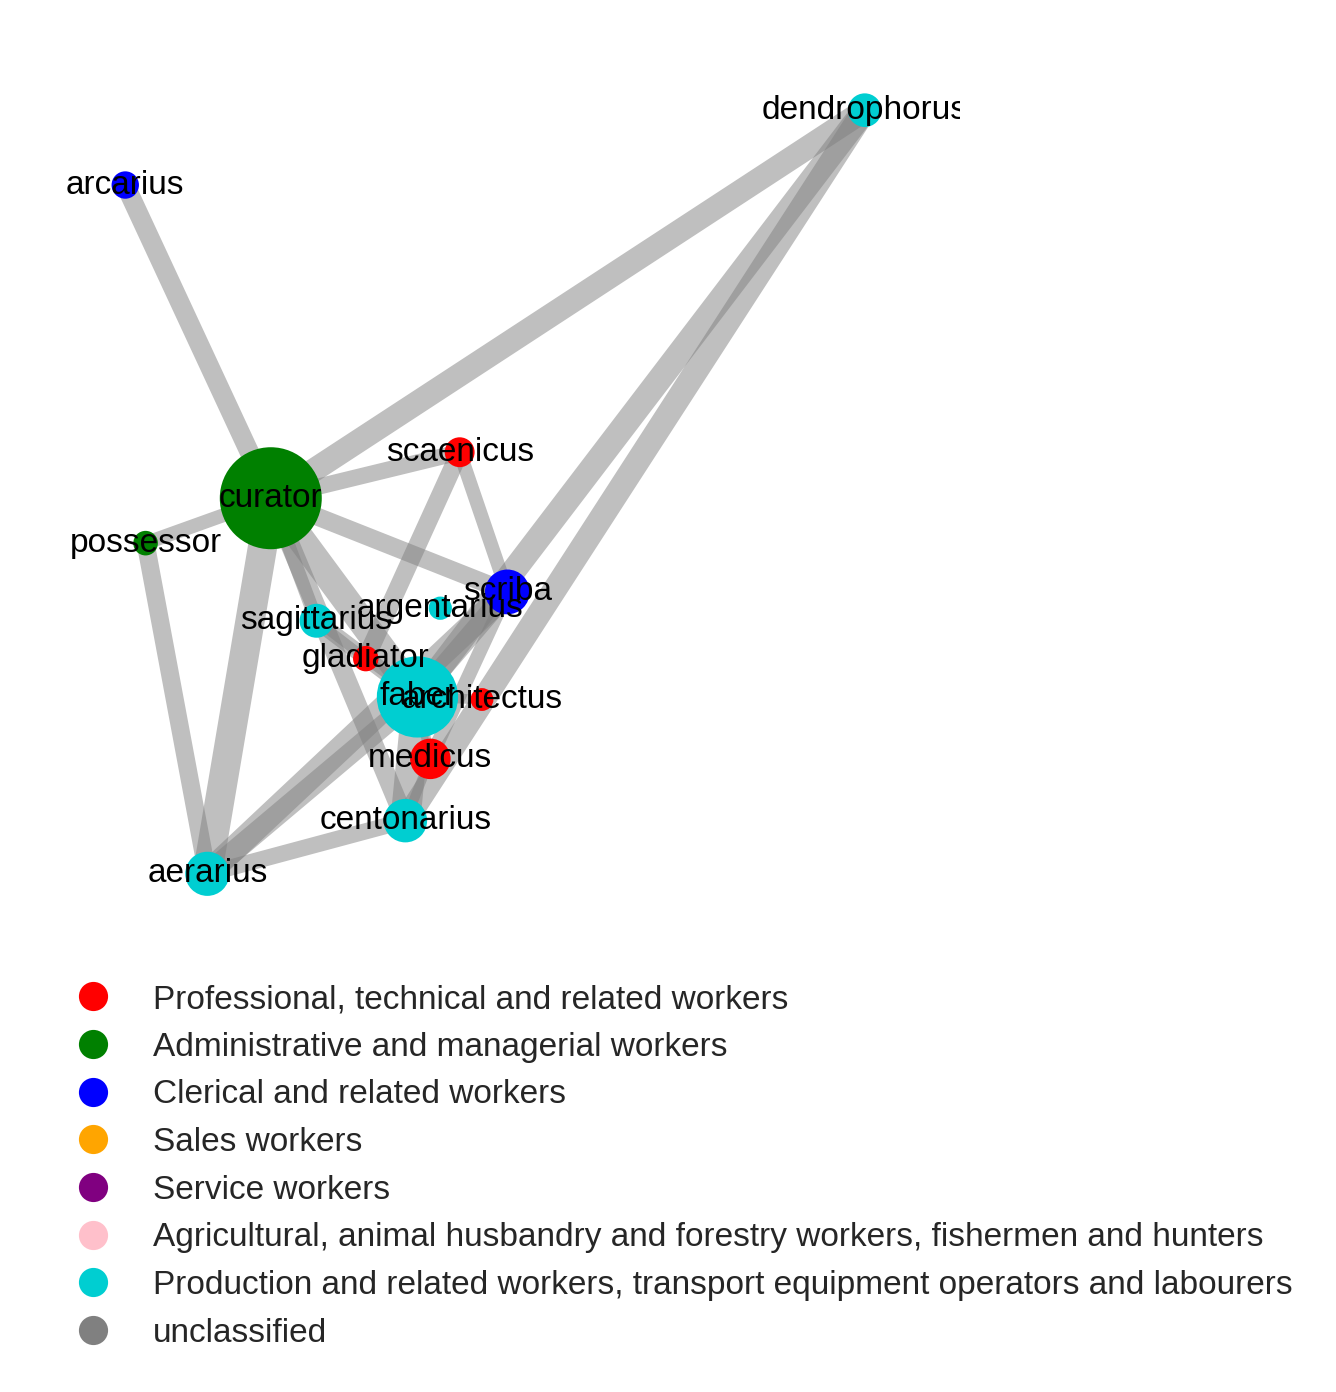

In [171]:
# All data
fig, ax = plt.subplots(figsize=(4, 4))
plot_network(G, N_nodes=14, legend_dict=hisco_colors_dict, ax=ax)

In [172]:
save_figure(fig, "LIST_occups_networks_all")

Unsupported file format. Type either "txt", "csv", "json", "geojson", "feather", or "png":  png


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_networks_all.png"
A file with the same name ("LIST_occups_networks_all.png") already exists in this location.


Press Enter to overwrite it or choose different path and filename:  


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_networks_all.png"


In [78]:
def network_from_stringlist(stringlist):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(stringlist)
    Xc = X.T * X
    wordcounts = X.toarray().sum(axis=0)
    nodes_dict = dict([(pair[1], {"wordcount" : wordcounts[pair[1]]}) for pair in vectorizer.vocabulary_.items()])
    labels_mapping = dict([(pair[1], pair[0]) for pair in vectorizer.vocabulary_.items()])
    G = nx.from_numpy_array(Xc.toarray())
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.set_node_attributes(G, nodes_dict)
    G = nx.relabel_nodes(G, labels_mapping)
    isolates = list(nx.isolates(G))
    G.remove_nodes_from(isolates)
    return G

In [95]:
G = network_from_stringlist(occupslist)

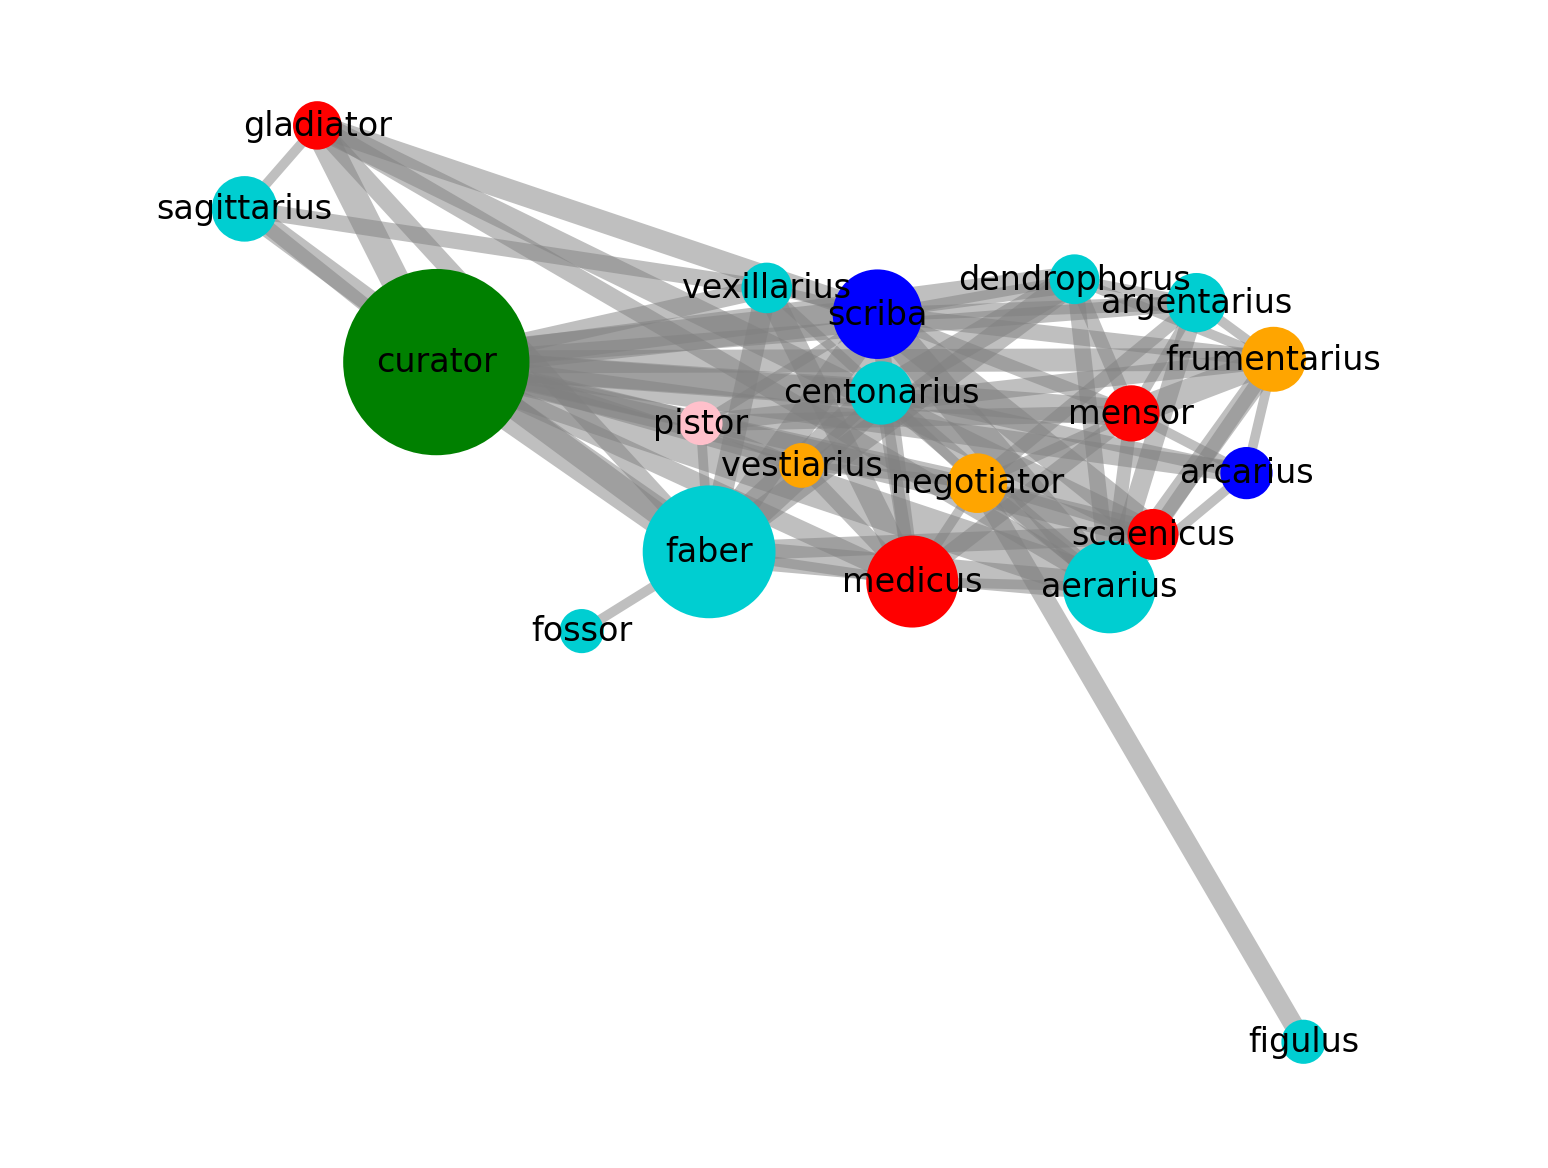

In [96]:
plot_network(G, N_nodes=20)

In [131]:
mask_large = LIST_occups["urban_context_alt"]=="large"
mask_medium = LIST_occups["urban_context_alt"]=="medium"
mask_small = LIST_occups["urban_context_alt"]=="small"

occupslist_large = [" ".join([el.replace(" ", "_") for el in olist]) for olist in LIST_occups[mask_large]["occups"].tolist()]
occupslist_medium = [" ".join([el.replace(" ", "_") for el in olist]) for olist in LIST_occups[mask_medium]["occups"].tolist()]
occupslist_small = [" ".join([el.replace(" ", "_") for el in olist]) for olist in LIST_occups[mask_small]["occups"].tolist()]

In [121]:
mask_large

5         False
57         True
66         True
78         True
145       False
          ...  
511598    False
511756    False
511807    False
511899    False
511900    False
Name: urban_context_alt, Length: 8339, dtype: bool

In [124]:
G_large = network_from_stringlist(occupslist_large)
G_medium = network_from_stringlist(occupslist_medium)
G_small = network_from_stringlist(occupslist_small)

In [101]:
len(G_large.nodes)

203

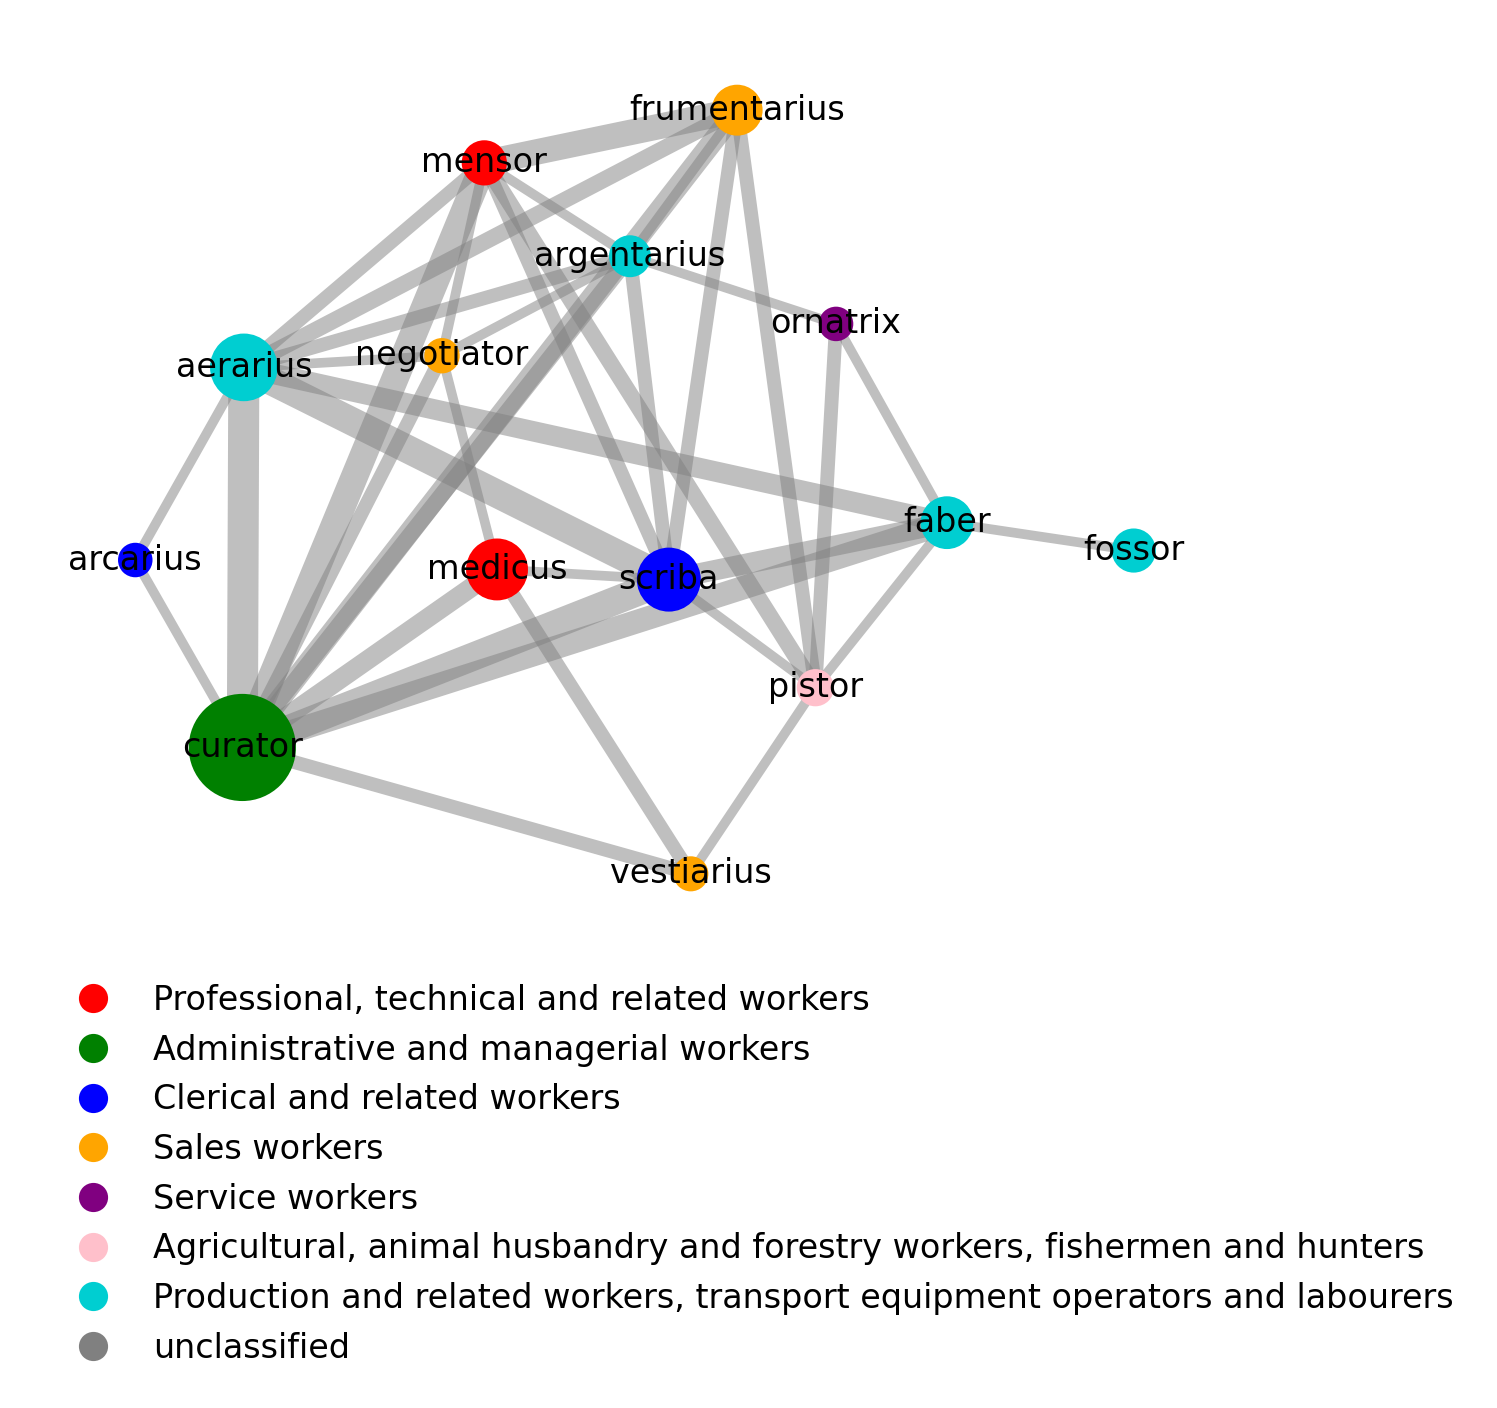

In [108]:
# large cities
fig, ax = plt.subplots(figsize=(5.2, 4))
plot_network(G_large, N_nodes=14, legend_dict=hisco_colors_dict, ax=ax)

In [173]:
save_figure(fig, "LIST_occups_networks_large_cities")

Unsupported file format. Type either "txt", "csv", "json", "geojson", "feather", or "png":  png


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_networks_large_cities.png"
A file with the same name ("LIST_occups_networks_large_cities.png") already exists in this location.


Press Enter to overwrite it or choose different path and filename:  


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_networks_large_cities.png"


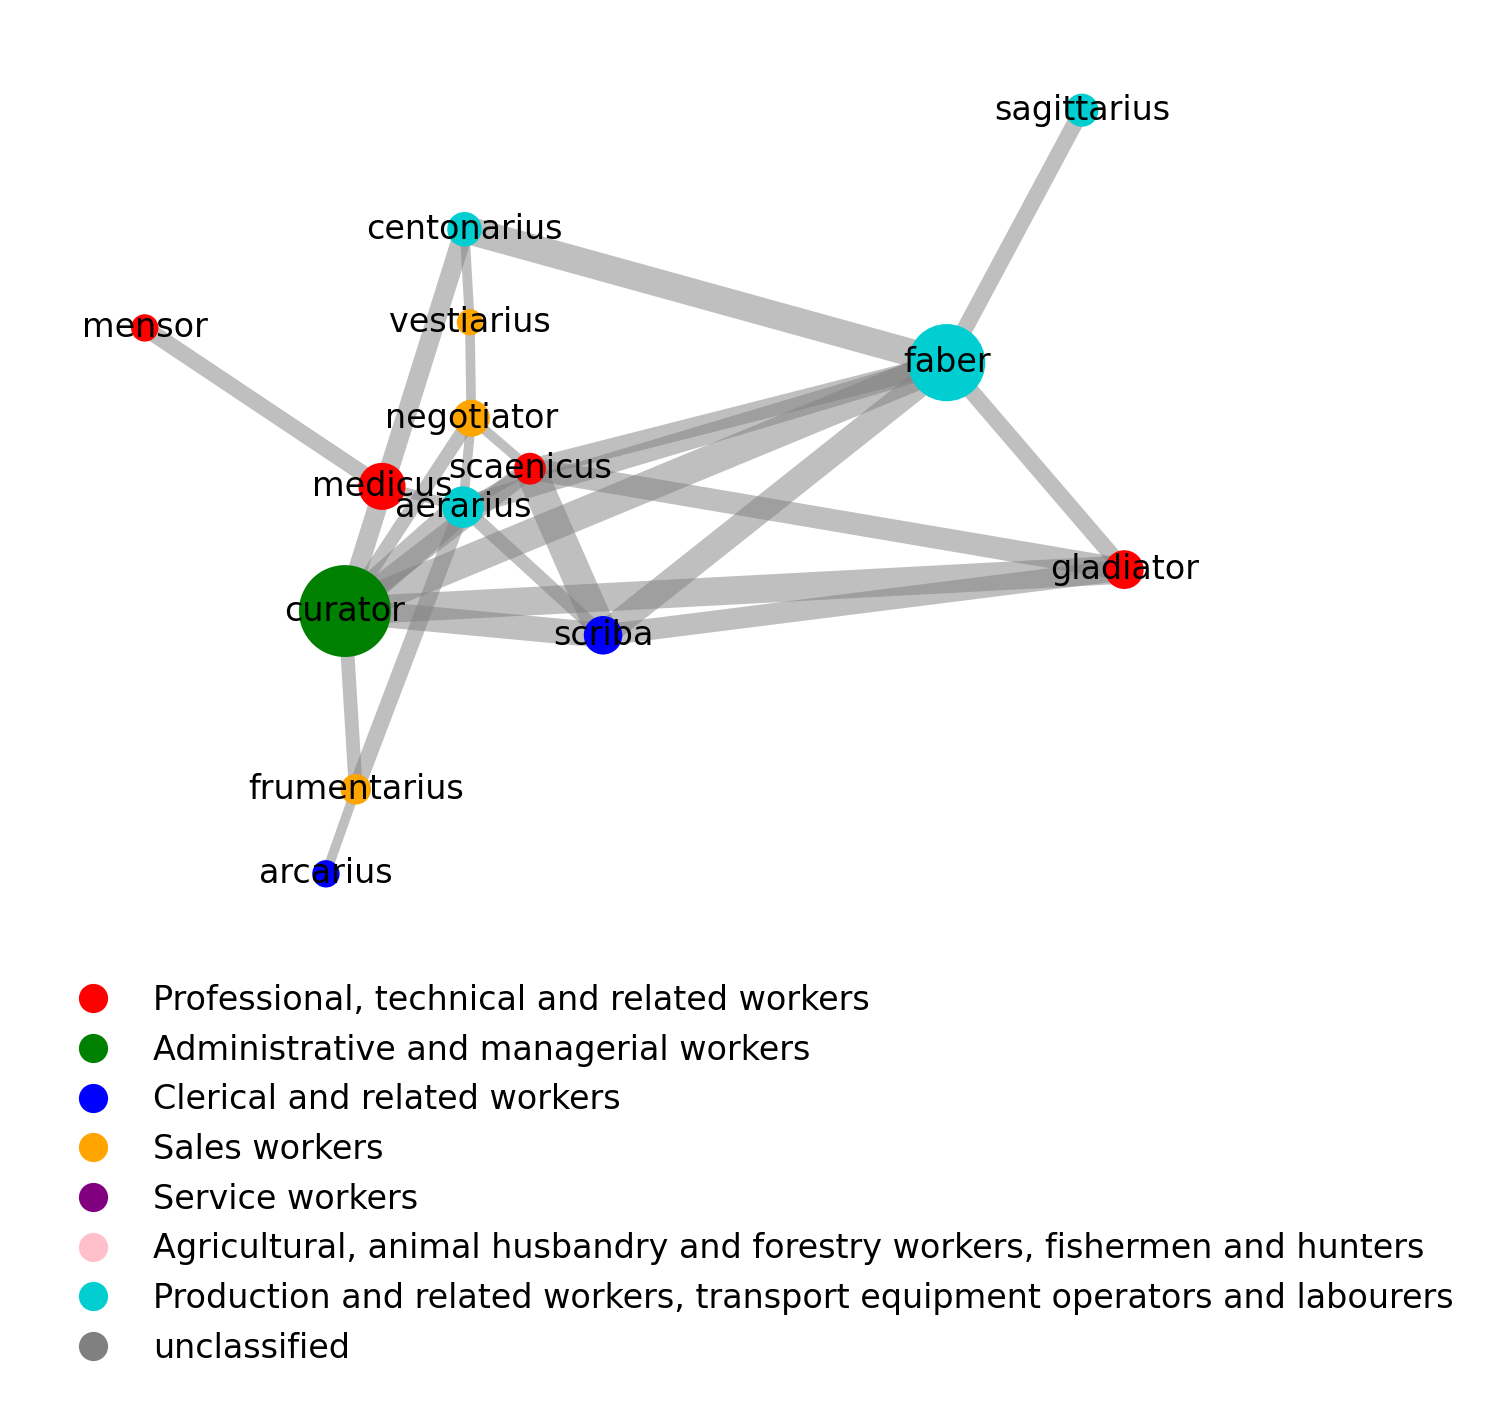

In [129]:
# medium cities
fig, ax = plt.subplots(figsize=(5.2, 4))
plot_network(G_medium, N_nodes=14, legend_dict=hisco_colors_dict, ax=ax)

In [174]:
save_figure(fig, "LIST_occups_networks_medium_cities")

Unsupported file format. Type either "txt", "csv", "json", "geojson", "feather", or "png":  png


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_networks_medium_cities.png"
A file with the same name ("LIST_occups_networks_medium_cities.png") already exists in this location.


Press Enter to overwrite it or choose different path and filename:  


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_networks_medium_cities.png"


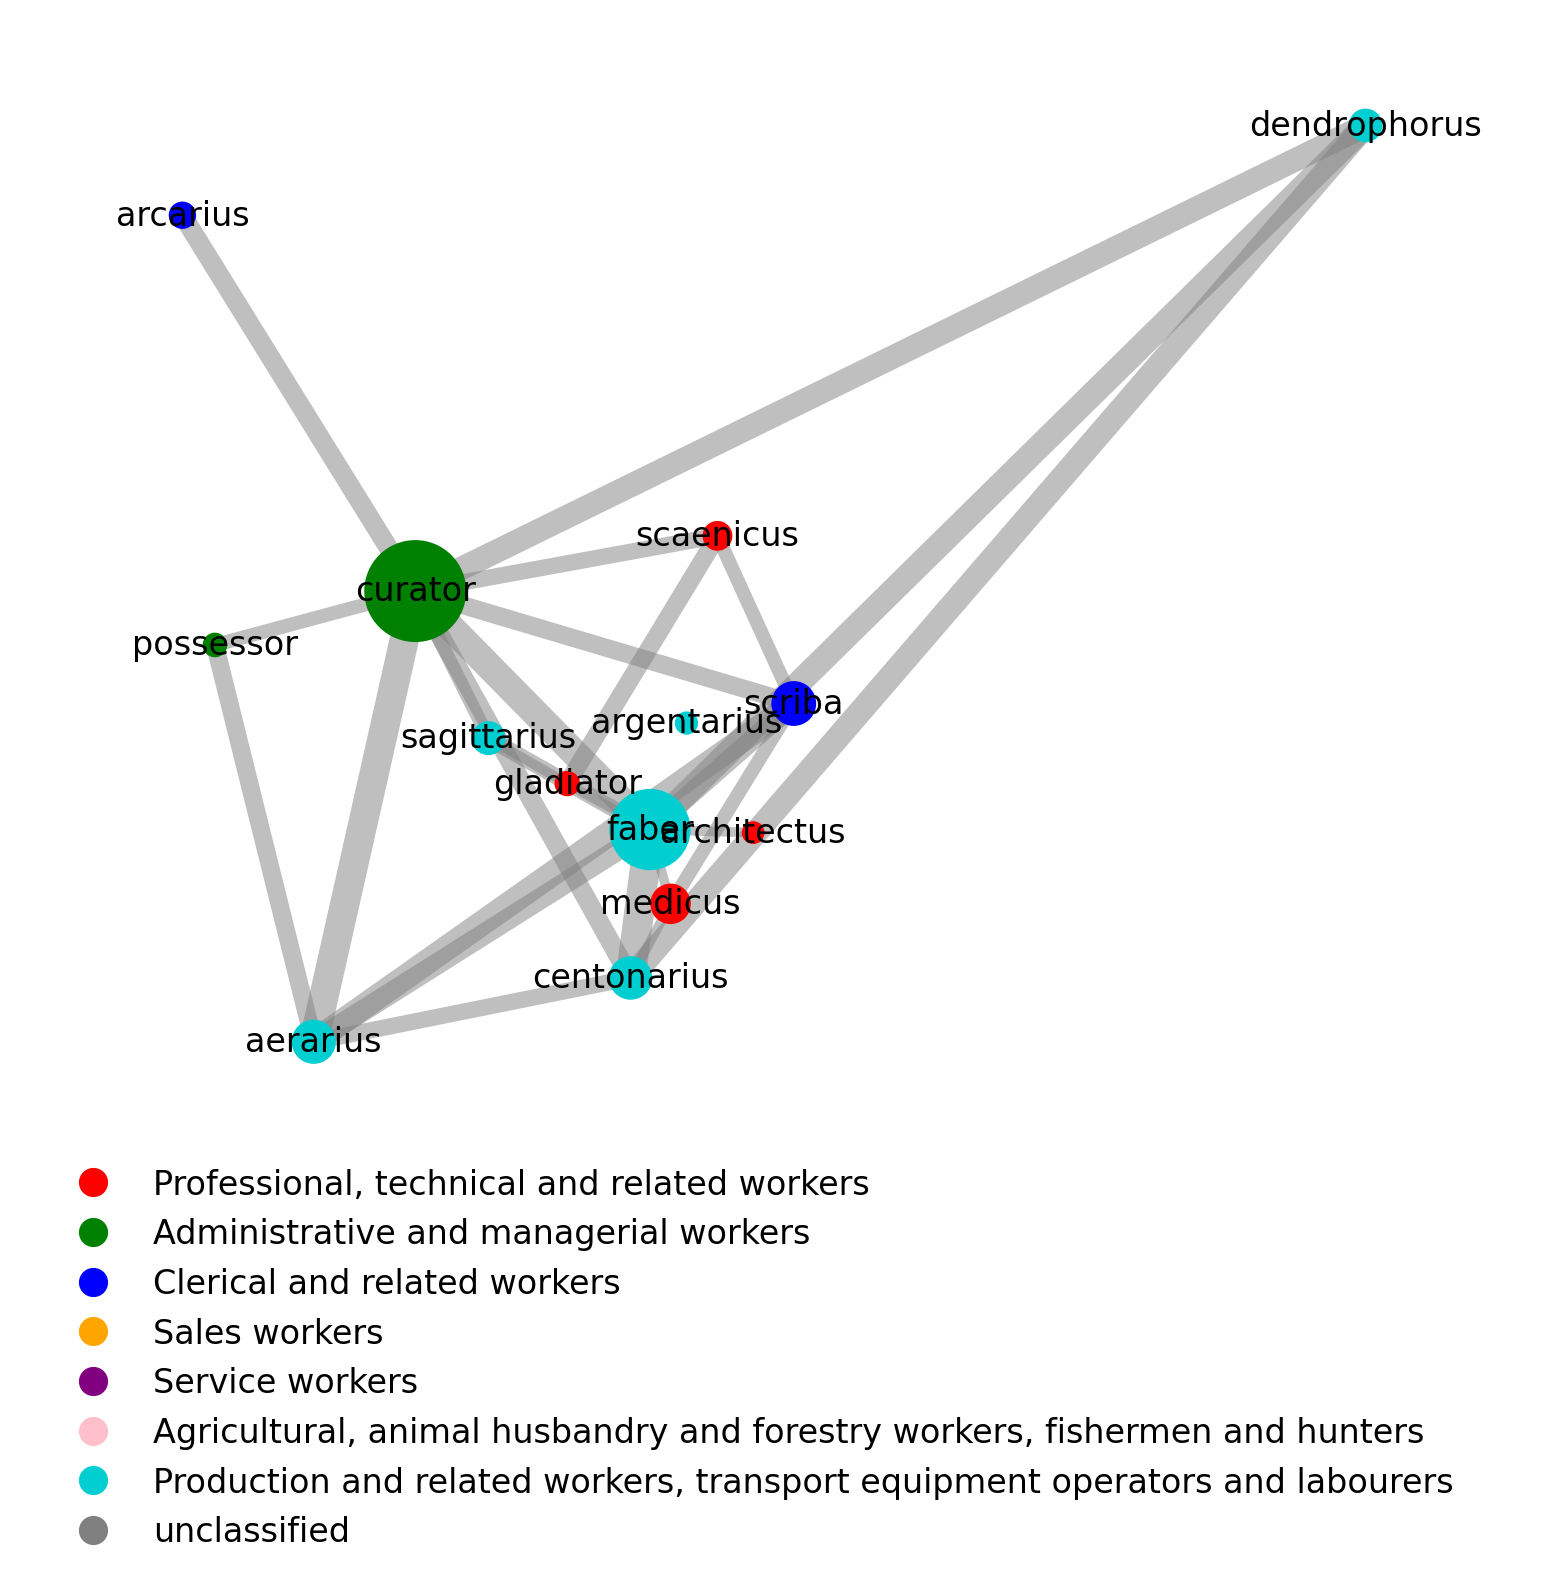

In [118]:
# small cities
plot_network(G_small, N_nodes=14, legend_dict=hisco_colors_dict)

In [175]:
save_figure(fig, "LIST_occups_networks_small_cities")

Unsupported file format. Type either "txt", "csv", "json", "geojson", "feather", or "png":  png


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_networks_small_cities.png"
A file with the same name ("LIST_occups_networks_small_cities.png") already exists in this location.


Press Enter to overwrite it or choose different path and filename:  


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_networks_small_cities.png"


In [132]:
weight_inv_dict = dict([((e[0], e[1]), {"weight_inv" : 1 / e[2]["weight"]}) for e in G_large.edges(data=True)])

In [133]:
dict(zip([((e[0], e[1]), {"weight_inv" : 1 / e[2]["weight"]}) for e in G_large.edges(data=True)]))

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [134]:
Gs = [G_large, G_medium, G_small]
nodes_dfs = []
for G in Gs:
    degree = nx.degree_centrality(G)
    nx.set_node_attributes(G, degree, "degree")
    betweenness = nx.betweenness_centrality(G)
    nx.set_node_attributes(G, betweenness, "betweenness")
    weight_inv_dict = dict([((e[0], e[1]), {"weight_inv" : 1 / e[2]["weight"]}) for e in G_large.edges(data=True)])
    nx.set_edge_attributes(G, weight_inv_dict)
    closeness = nx.closeness_centrality(G, distance="weight_inv")
    nx.set_node_attributes(G, closeness, "closeness")
    nodes_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
    nodes_df["bb/log2(wordc)"] =  nodes_df.apply(lambda row: row["betweenness"] / np.log2(row["wordcount"]), axis=1)
    nodes_dfs.append(nodes_df)

In [135]:
G_large.edges(data=True)

EdgeDataView([('acceptor', 'aeneator', {'weight': 2, 'weight_inv': 0.5}), ('acceptor', 'aerarius', {'weight': 2, 'weight_inv': 0.5}), ('acceptor', 'asinarius', {'weight': 2, 'weight_inv': 0.5}), ('acceptor', 'curator', {'weight': 6, 'weight_inv': 0.16666666666666666}), ('acceptor', 'dissignator', {'weight': 2, 'weight_inv': 0.5}), ('acceptor', 'frumentarius', {'weight': 1, 'weight_inv': 1.0}), ('acceptor', 'mensor', {'weight': 2, 'weight_inv': 0.5}), ('acceptor', 'nauticarius', {'weight': 1, 'weight_inv': 1.0}), ('acceptor', 'pantomimus', {'weight': 18, 'weight_inv': 0.05555555555555555}), ('acceptor', 'scaenicus', {'weight': 2, 'weight_inv': 0.5}), ('acceptor', 'tibicinus', {'weight': 2, 'weight_inv': 0.5}), ('aedifex', 'aerarius', {'weight': 4, 'weight_inv': 0.25}), ('aedifex', 'curator', {'weight': 2, 'weight_inv': 0.5}), ('aedifex', 'possessor', {'weight': 8, 'weight_inv': 0.125}), ('aeneator', 'aerarius', {'weight': 1, 'weight_inv': 1.0}), ('aeneator', 'asinarius', {'weight': 1, '

In [136]:
nodes_dfs[0][['wordcount', 'degree', 'betweenness', 'closeness']].corr()

,wordcount,degree,betweenness,closeness
wordcount,1.000000,0.777290,0.884602,0.369289
degree,0.777290,1.000000,0.757276,0.603293
betweenness,0.884602,0.757276,1.000000,0.322201
closeness,0.369289,0.603293,0.322201,1.000000


In [137]:
nodes_dfs[1][['wordcount', 'degree', 'betweenness', 'closeness']].corr()

,wordcount,degree,betweenness,closeness
wordcount,1.000000,0.551483,0.798590,0.347571
degree,0.551483,1.000000,0.716947,0.474003
betweenness,0.798590,0.716947,1.000000,0.423270
closeness,0.347571,0.474003,0.423270,1.000000


In [138]:
nodes_dfs[2][['wordcount', 'degree', 'betweenness', 'closeness']].corr()

,wordcount,degree,betweenness,closeness
wordcount,1.000000,0.538212,0.860753,0.360615
degree,0.538212,1.000000,0.638483,0.488545
betweenness,0.860753,0.638483,1.000000,0.423692
closeness,0.360615,0.488545,0.423692,1.000000


In [139]:
nodes_dfs[0].sort_values("closeness", ascending=False).head(20)

,wordcount,degree,betweenness,closeness,bb/log2(wordc)
curator,611,0.371287,0.418966,1.019907,0.045269
aerarius,232,0.217822,0.080051,0.998449,0.010187
pantomimus,20,0.044554,0.000671,0.985389,0.000155
scriba,206,0.193069,0.089242,0.984110,0.011610
mensor,97,0.133663,0.031683,0.970733,0.004800
nauta,36,0.069307,0.010387,0.968895,0.002009
negotians,49,0.089109,0.062969,0.963371,0.011215
faber,136,0.173267,0.158068,0.948844,0.022302
acceptor,8,0.054455,0.002395,0.932251,0.000798
eborarius,9,0.024752,0.004606,0.931823,0.001453


In [140]:
metrics = [
    ('wordcount', 0.3, "wordcount"),
    ('degree', 0.1, "degree"),
    ('betweenness', -0.1, "betweenness"),
    ('closeness', -0.3, "closeness")]

color_values = ["blue", "red", "green", "purple"] # , "orange"]

In [141]:
pd.reset_option("^display")

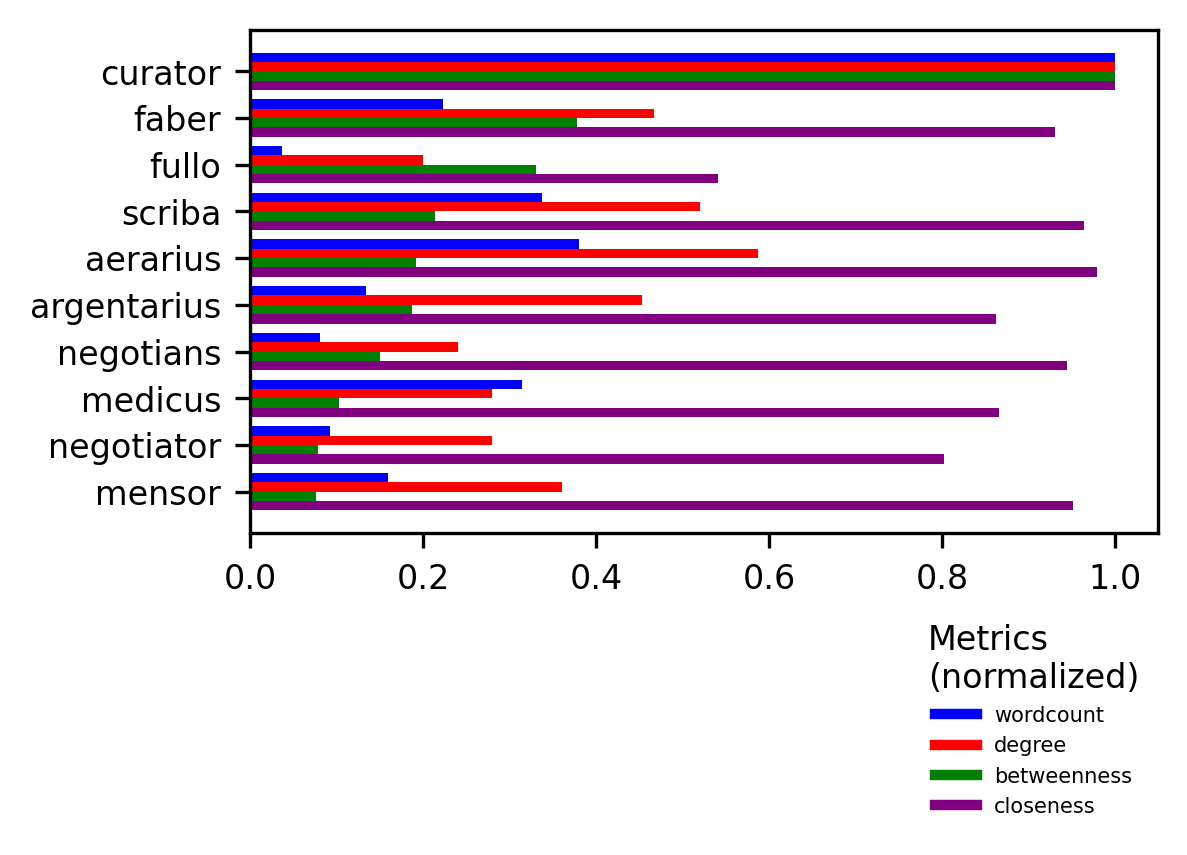

In [156]:
data_all = nodes_dfs[0].sort_values("betweenness", ascending=False)
N = 10
data = data_all.head(N)
idx = np.array([n for n in reversed(range(0, len(data)))])
fig, ax = plt.subplots(figsize=[4, 2.6], tight_layout=True)

for cent, color in zip(metrics, color_values):
    ax.barh(y=idx + cent[1], width=data[cent[0]].apply(lambda x: x / data_all[cent[0]].max()), height=0.2, color=color)
ax.set_yticks(idx)
ax.set_yticklabels(data.index)

markers = [plt.Line2D([0,0],[0,0],color=color, linewidth=2.5) for color in color_values]
plt.legend(markers, [cent[2] for cent in metrics], ncol=1, numpoints=1,  title="Metrics\n(normalized)", fontsize=5, bbox_to_anchor=(1,-0.6), loc="lower right", frameon=False)

In [176]:
save_figure(fig, "LIST_occups_networks_occups_measures")

Unsupported file format. Type either "txt", "csv", "json", "geojson", "feather", or "png":  png


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_networks_occups_measures.png"
A file with the same name ("LIST_occups_networks_occups_measures.png") already exists in this location.


Press Enter to overwrite it or choose different path and filename:  


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_networks_occups_measures.png"


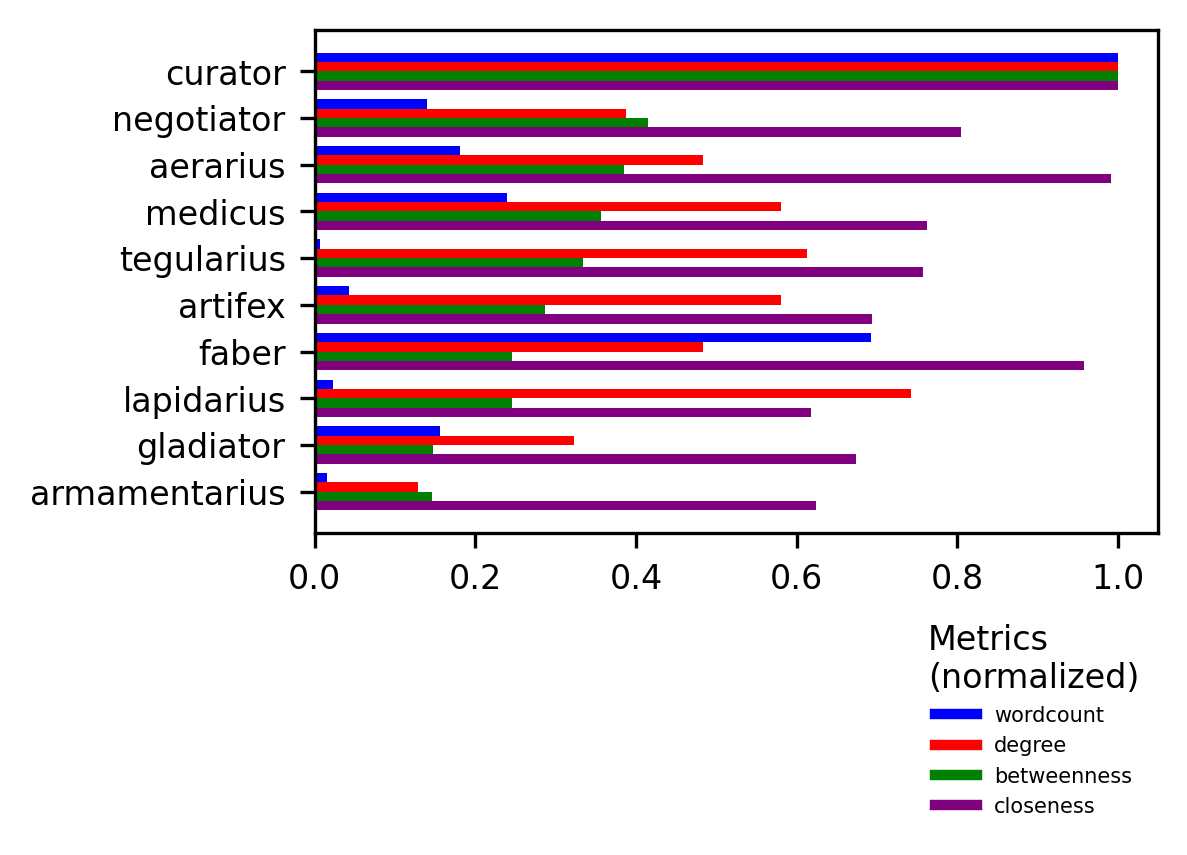

In [160]:
# sorted by betweenness

data_all = nodes_dfs[1].sort_values("betweenness", ascending=False)
N = 10
data = data_all.head(N)
idx = np.array([n for n in reversed(range(0, len(data)))])
fig, ax = plt.subplots(figsize=[4, 2.6], tight_layout=True)

for cent, color in zip(metrics, color_values):
    ax.barh(y=idx + cent[1], width=data[cent[0]].apply(lambda x: x / data_all[cent[0]].max()), height=0.2, color=color)
ax.set_yticks(idx)
ax.set_yticklabels(data.index)

markers = [plt.Line2D([0,0],[0,0],color=color, linewidth=2.5) for color in color_values]
plt.legend(markers, [cent[2] for cent in metrics], ncol=1, numpoints=1,  title="Metrics\n(normalized)", fontsize=5, bbox_to_anchor=(1,-0.6), loc="lower right", frameon=False)

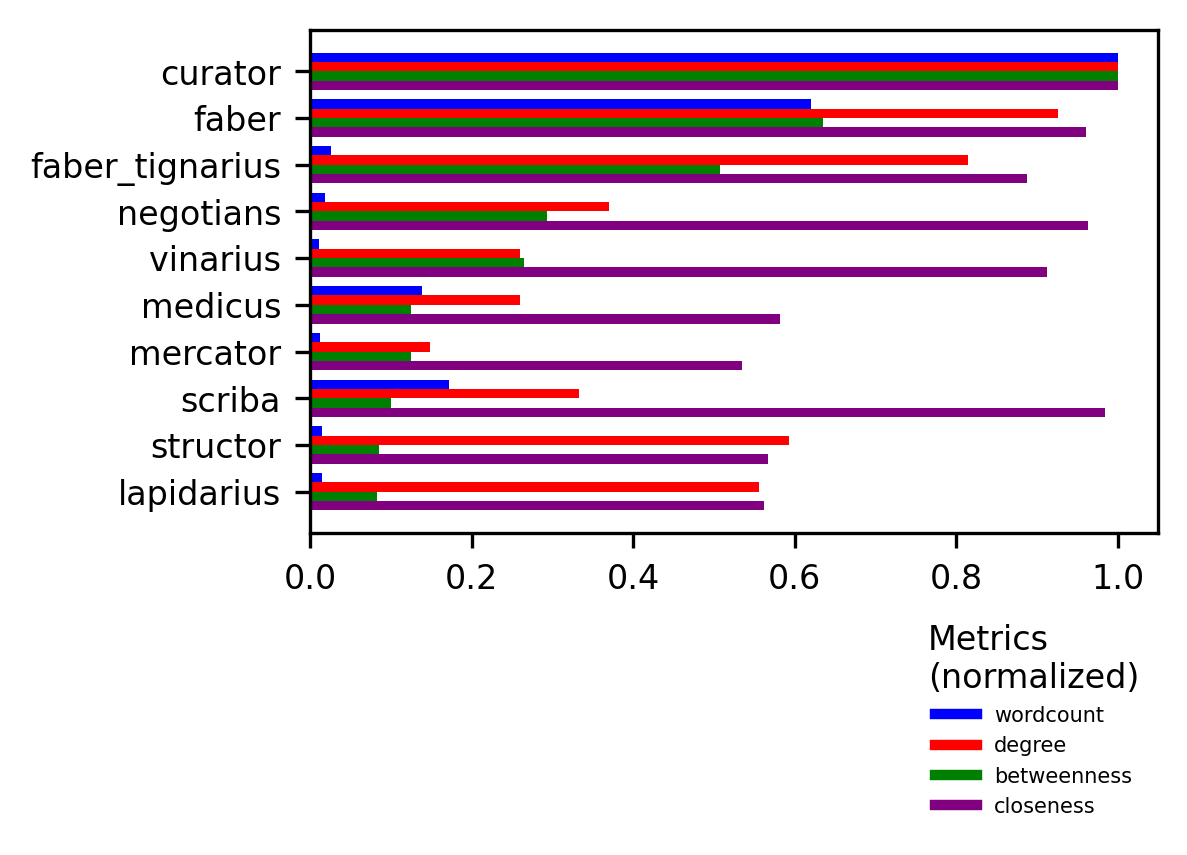

In [161]:
# sorted by betweenness

data_all = nodes_dfs[2].sort_values("betweenness", ascending=False)
N = 10
data = data_all.head(N)
idx = np.array([n for n in reversed(range(0, len(data)))])
fig, ax = plt.subplots(figsize=[4, 2.6], tight_layout=True)

for cent, color in zip(metrics, color_values):
    ax.barh(y=idx + cent[1], width=data[cent[0]].apply(lambda x: x / data_all[cent[0]].max()), height=0.2, color=color)
ax.set_yticks(idx)
ax.set_yticklabels(data.index)

markers = [plt.Line2D([0,0],[0,0],color=color, linewidth=2.5) for color in color_values]
plt.legend(markers, [cent[2] for cent in metrics], ncol=1, numpoints=1,  title="Metrics\n(normalized)", fontsize=5, bbox_to_anchor=(1,-0.6), loc="lower right", frameon=False)

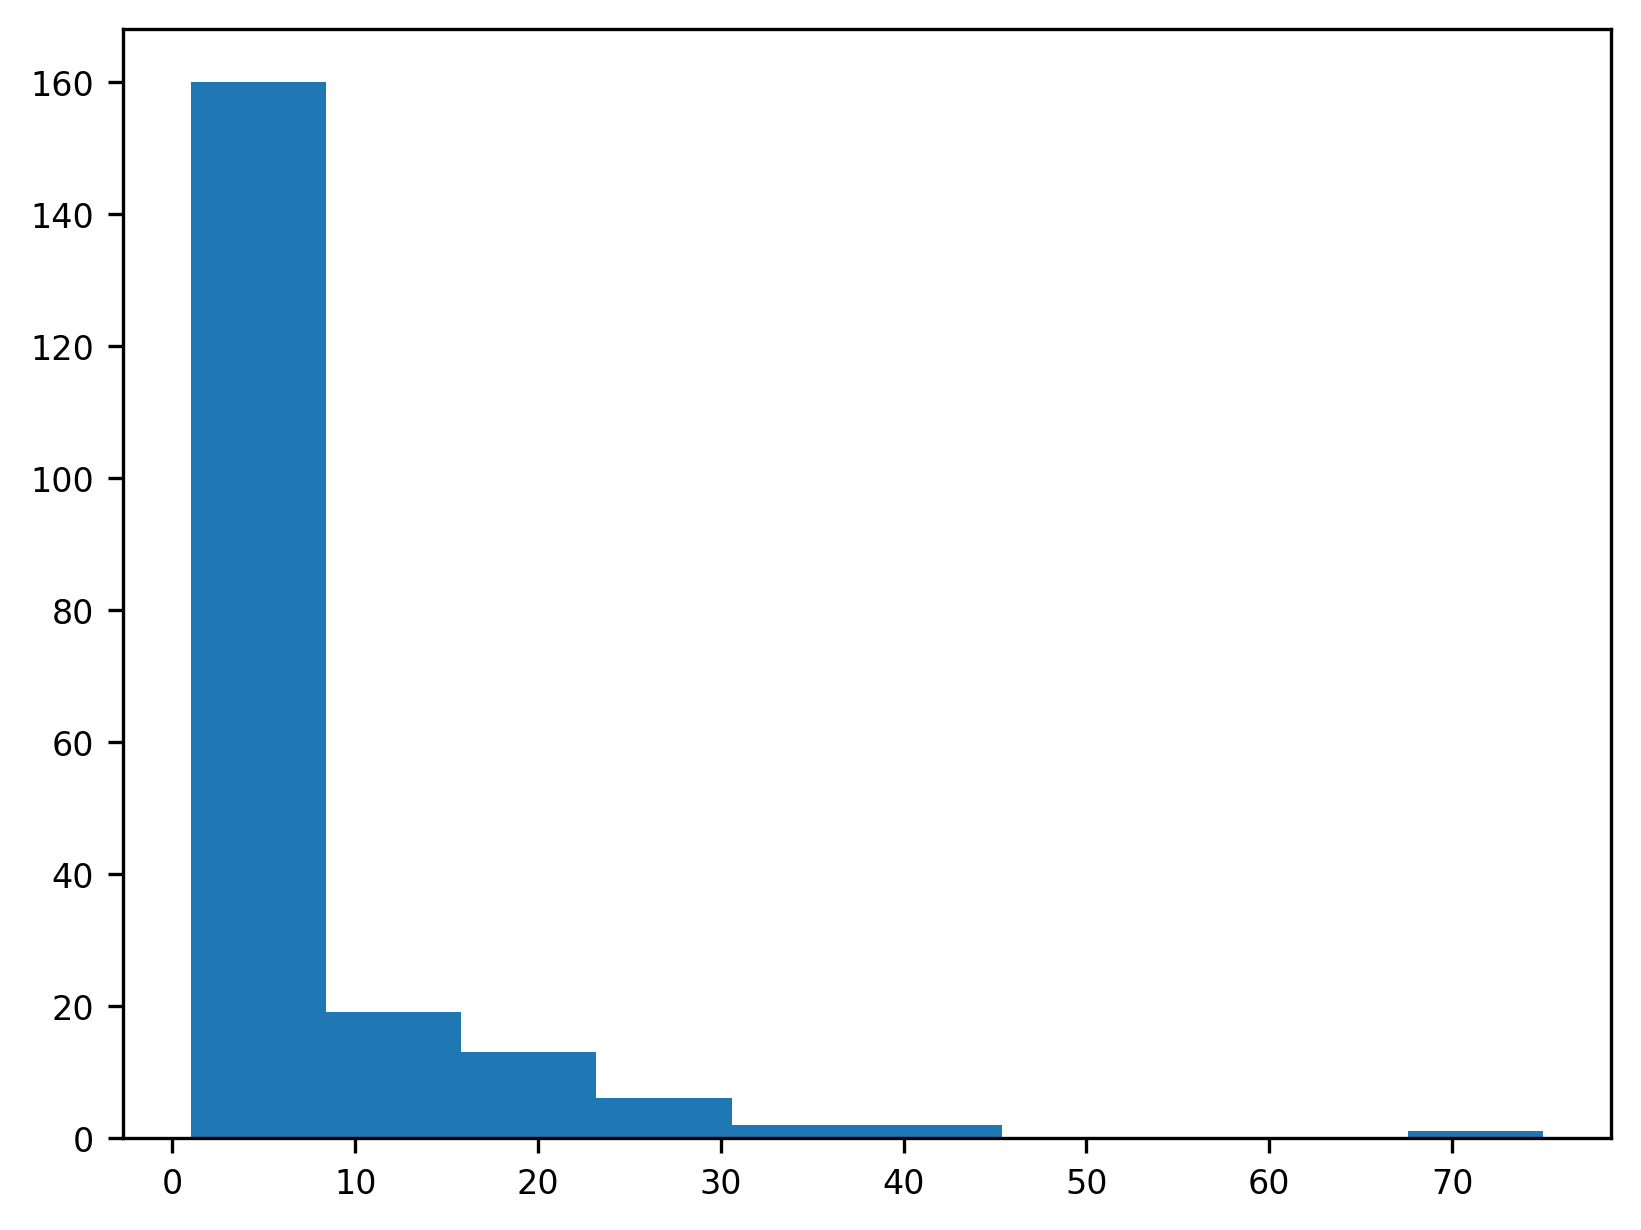

In [162]:
degrees = sorted([G_large.degree(n) for n in G_large.nodes()], reverse=True)
plt.hist(degrees)
plt.show()

In [163]:
# do we have scale free networks?
# based on https://stackoverflow.com/questions/49908014/how-can-i-check-if-a-network-is-scale-free

def check_powerlaw(Graph):
    degrees = sorted([Graph.degree(n) for n in Graph.nodes()], reverse=True)
    fig = plt.hist(degrees)
    fit = powerlaw.Fit(degrees, xmin=1) 
    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    print(R, p<0.05)
    return fig, R, p

3.1805784448831433 True


(array([160.,  19.,  13.,   6.,   2.,   2.,   0.,   0.,   0.,   1.]),
 array([ 1. ,  8.4, 15.8, 23.2, 30.6, 38. , 45.4, 52.8, 60.2, 67.6, 75. ]),
 <BarContainer object of 10 artists>)

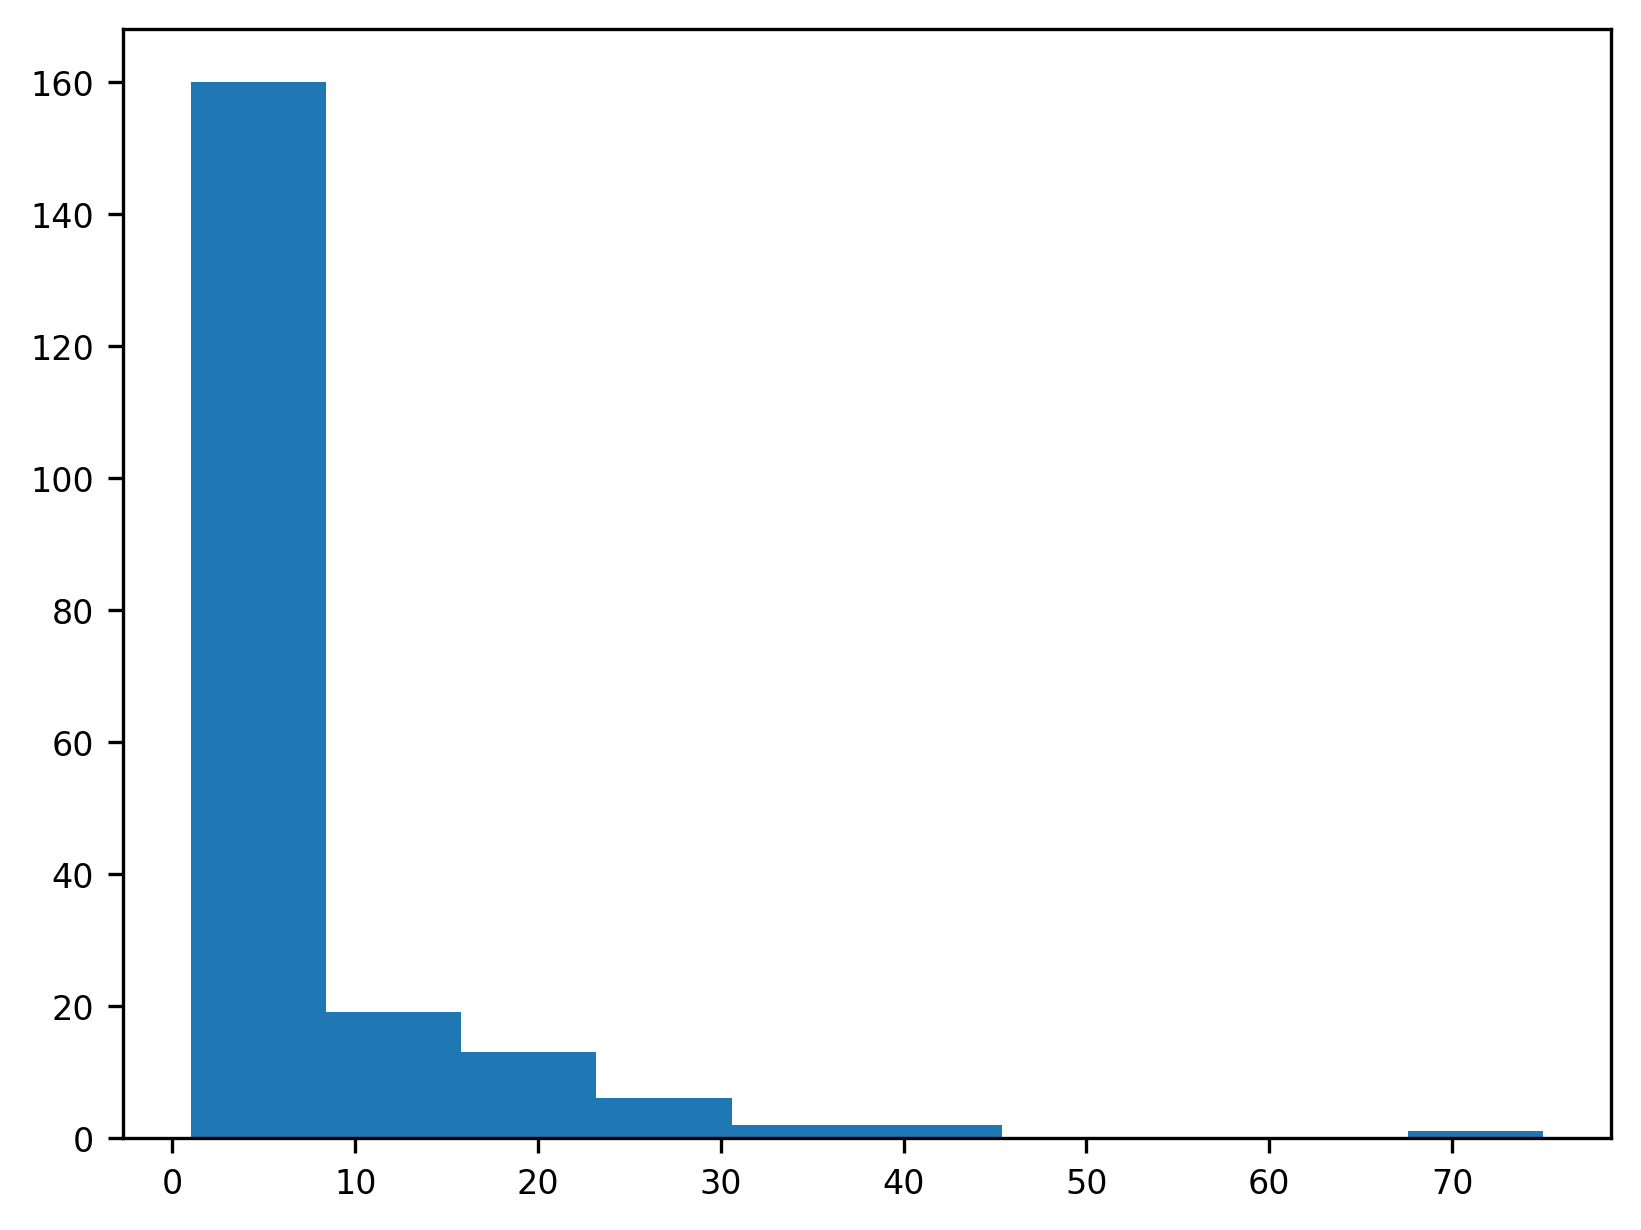

In [164]:
fig, R, p = check_powerlaw(G_large)
fig

In [165]:
# but
degrees = sorted([G_large.degree(n) for n in G_large.nodes()], reverse=True)
fit = powerlaw.Fit(degrees, xmin=1)
fit.distribution_compare('power_law', 'lognormal')

(-2.1487028898260596, 0.256493109610197)